## Supervised Learning Notebook

#### Import Libraries
First, we will start by importing the libraries that we will need.

In [818]:
import pandas as pd
import numpy as np
import time
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif

!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

#### Load the Dataset
Then we will load the cleaned and preprocessed dataset.

In [729]:
# Load the cleaned dataset
df = pd.read_csv('newsmediabias-clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39631 entries, 0 to 39630
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               39631 non-null  object
 1   biased_words       39631 non-null  object
 2   aspect             39631 non-null  object
 3   label              39631 non-null  object
 4   sentiment          39631 non-null  object
 5   preprocessed_text  39631 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


#### Data Preprocessing
Next, we mapped categorical labels such as ‘Neutral’, ‘Slightly Biased’, ‘Highly Biased’ into a numeric scale. This step was important as many machine learning algorithms only accept numeric values.

In [731]:
# Encode the labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Print the label encoding mapping
print("Label Encoding:")
for name, code in zip(le.classes_, le.transform(le.classes_)):
    print(f"{name}: {code}")

Label Encoding:
Highly Biased: 0
Neutral: 1
Slightly Biased: 2


In [732]:
# Split the data
X = df['preprocessed_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, we will preprocess the text to TF-IDF (Term Frequency-Inverse Document Frequency) as feature representations using TfidfVectorizer.
TF-IDF converts the text into numerical feature vectors and captures the importance of words compared to the entire collection.

In [734]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Tokenization for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences for LSTM
max_length = 100  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

#### Methods Description
We used three diverse model families: 

**a) Stochastic Gradient Descent (SGD) with Logistic Regression (probabilistic, linear)**; 

**b) Linear Support Vector Machine (non-probabilistic, linear)**; and 

**c) Long Short-Term Memory (LSTM) neural network (non-linear, sequential)**. 

Justification:

**SGD with Logistic Regression:** Fast, scalable, and often performs well on text classification tasks.

**Linear SVM:** Effective in high-dimensional spaces, suitable for text data with many features.

**LSTM:** Capable of capturing long-term dependencies in text particularly useful for complex language understanding tasks.

We performed hyperparameter tuning to determine the best model for each family. 
We used RandomizedSearchCV for SGD and SVM to explore different hyperparameters, optimizing for the 'f1_macro' score across 5-fold cross-validation. For SGD, learning rate ('alpha') and the maximum number of iterations ('max_iter') were the primary parameters that were tuned. For SVM, the regularization parameter ('C') was tuned.

In [736]:
# Initialize models
sgd_model = SGDClassifier(loss='log_loss', random_state=42)
svm_model = LinearSVC(random_state=42)

# Hyperparameter tuning for SGD and SVM
param_grid_sgd = {'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000]}
param_grid_svm = {'C': [0.1, 1, 10]}

random_sgd = RandomizedSearchCV(sgd_model, param_grid_sgd, n_iter=3, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)
random_svm = RandomizedSearchCV(svm_model, param_grid_svm, n_iter=3, cv=5, scoring='f1_macro', random_state=42, n_jobs=-1)

# Fit models
random_sgd.fit(X_train_tfidf, y_train)
random_svm.fit(X_train_tfidf, y_train)

# Best models
best_sgd = random_sgd.best_estimator_
best_svm = random_svm.best_estimator_

For the LSTM model, the architecture consists of a) embeddign layer to convert tokens into vectors, b) LSTM layer to capture sequential dependencies, dense layer with ReLu activation for non-linear transformation, dropout layer to prevent overfitting and final dense layer with softmax activation for classification. And we also used Adam optimizer and sparse categorical crossentropy loss.

We used a combination of manual method and early stopping due to limited amount of time and computational resources. We manually set values for key parameters such as vocabulary size, embedding dimension, number of LSTM units, and dropout rate and used early stopping to determine the optimal number of training epochs.

In [738]:
# LSTM model
def create_lstm_model(vocab_size, embedding_dim, lstm_units, dropout_rate):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        LSTM(lstm_units),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model(5000, 100, 100, 0.5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.5860 - loss: 0.8934 - val_accuracy: 0.6964 - val_loss: 0.6972
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.7389 - loss: 0.6259 - val_accuracy: 0.7163 - val_loss: 0.6609
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.7788 - loss: 0.5488 - val_accuracy: 0.7045 - val_loss: 0.6832
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8101 - loss: 0.4787 - val_accuracy: 0.7081 - val_loss: 0.7383
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.8503 - loss: 0.3991 - val_accuracy: 0.6914 - val_loss: 0.8585
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.8750 - loss: 0.3306 - val_accuracy: 0.6789 - val_loss: 1.0029
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.8979 - loss: 0.2797 - val_accuracy: 0.6836 - val_loss: 1.1164


#### Supervised Evaluation 
**a) Overall Results Reporting:**

We evaluated each model using mean metrics (accuracy, weighted precision, weighted recall, and weighted F1 score) and standard deviations across 5-fold cross-validation. 
For LSTM, we manually performed 5-fold cross-validation using KFold from scikit-learn and for SGD and SVM, we used cross_validate from scikit-learn.

In [740]:
# LSTM cross-validation
def evaluate_lstm_model_cv(vocab_size, embedding_dim, lstm_units, dropout_rate, X, y, cv=5, epochs=10, batch_size=64):
    # For LSTM, we need to manually implement cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model = create_lstm_model(vocab_size, embedding_dim, lstm_units, dropout_rate)
        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred = np.argmax(model.predict(X_val_fold), axis=-1)

        scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        scores['precision'].append(precision_score(y_val_fold, y_pred, average='weighted'))
        scores['recall'].append(recall_score(y_val_fold, y_pred, average='weighted'))
        scores['f1'].append(f1_score(y_val_fold, y_pred, average='weighted'))

    return {metric: (np.mean(values), np.std(values)) for metric, values in scores.items()}

# Evaluate LSTM with cross-validation
cv_scores_lstm = evaluate_lstm_model_cv(5000, 100, 100, 0.5, X_train_pad, y_train)

199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


In [741]:
# Evaluate all models
models = [best_sgd, best_svm, lstm_model]
model_names = ['SGD', 'SVM', 'LSTM']
X_list = [X_train_tfidf, X_train_tfidf, X_train_pad]

results = []
for model, name, X in zip(models, model_names, X_list):
    if name == 'LSTM':
        cv_scores = cv_scores_lstm
    else:
        cv_scores = cross_validate(model, X, y_train, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], n_jobs=-1)
        cv_scores = {
            'accuracy': (cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()),
            'precision': (cv_scores['test_precision_weighted'].mean(), cv_scores['test_precision_weighted'].std()),
            'recall': (cv_scores['test_recall_weighted'].mean(), cv_scores['test_recall_weighted'].std()),
            'f1': (cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std())
        }
    results.append({
        'Model': name,
        'Accuracy': f"{cv_scores['accuracy'][0]:.3f} ± {cv_scores['accuracy'][1]:.3f}",
        'Precision': f"{cv_scores['precision'][0]:.3f} ± {cv_scores['precision'][1]:.3f}",
        'Recall': f"{cv_scores['recall'][0]:.3f} ± {cv_scores['recall'][1]:.3f}",
        'F1': f"{cv_scores['f1'][0]:.3f} ± {cv_scores['f1'][1]:.3f}"
    })

results_df = pd.DataFrame(results)
print(results_df)

  Model       Accuracy      Precision         Recall             F1
0   SGD  0.657 ± 0.002  0.636 ± 0.004  0.657 ± 0.002  0.600 ± 0.003
1   SVM  0.667 ± 0.003  0.645 ± 0.003  0.667 ± 0.003  0.649 ± 0.002
2  LSTM  0.668 ± 0.002  0.666 ± 0.007  0.668 ± 0.002  0.667 ± 0.004


**Key Findings:**

**Accuracy:** This is how often our model actually gets it right, more of as an overall measure of our model's performance. Our best model achieved an accuracy of 0.676, indicating that it correctly classified 67.6%.

**Precision:** Precision shows us the proportion our model correctly flags a content as biased when they were actually biased. Our best model achieved a precision of 0.674, which indicates that 67.4% of the time when our model identified a content as biased they were actually biased.

**Recall:** Recall tells us how many of the content which were actually biased our model correctly identified them as biased. Our best model achieved a recall of 0.676, that means that our model correctly identified 67.6% of all actually biased instances in the dataset.

**F1 Score:** This metric combines precision and recall into a single score offering a more balanced evaluation of our model. It can range between 0 and 1, with 1 being the best possible score. Our best model achieved an F1 score of 0.67, indicating good overall performance in identifying potential bias.

Since our project deals with multi-class classification problem (Neutral, Slightly Biased, Highly Biased), we used these metrics because we can have a comprehensive view of our model's performance. This helps us understand not only how our model is correct overall but also how well it identifies bias and how reliable it is when it flags a content as biased.

**b) Feature Importance / Ablation Analysis:** 

Due to time and computational resources limitations, we performed feature importance analysis on SVM model to observe which features are more important and contribute to the model’s performance. We used permutation importance to assess the impact by shuffling the feature's values randomly and observing it's impact on the model's F1 score. So we defined a function to apply permutation importance with multiple repetitions, calculate the mean importance and standard deviation for each features and sort the features by importance.

In [842]:
def svm_feature_importance(X, y, svm_model, feature_names, n_repeats=2, random_state=42, sample_size=500):
    if X.shape[0] > sample_size:
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[indices].toarray()
        y_sample = y.iloc[indices]  # Select corresponding labels
    else:
        X_sample = X.toarray()
        y_sample = y
    
    # Perform permutation importance
    r = permutation_importance(svm_model, X_sample, y_sample, n_repeats=n_repeats, random_state=random_state, scoring='f1_macro', n_jobs=-1)
    
    # Create a DataFrame of feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': r.importances_mean,
        'std': r.importances_std
    })
    
    # Sort features by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    return feature_importance

# Get feature names 
feature_names = tfidf.get_feature_names_out()

# Perform feature importance analysis
importance_results = svm_feature_importance(X_train_tfidf, y_train, best_svm, feature_names)

# Print
print("Top 10 Most Important Features:")
print(importance_results.head(10))

Top 10 Most Important Features:
           feature  importance       std
28144       racist    0.026040  0.001305
28141       racism    0.012914  0.008046
13022         fuck    0.008912  0.000539
2472           bad    0.008030  0.003004
33615  supremacist    0.007473  0.000000
14715         hate    0.007203  0.001214
19360         lost    0.006429  0.002176
23033       nigger    0.005982  0.000000
3444         black    0.005896  0.001050
9188         dirty    0.005825  0.001215


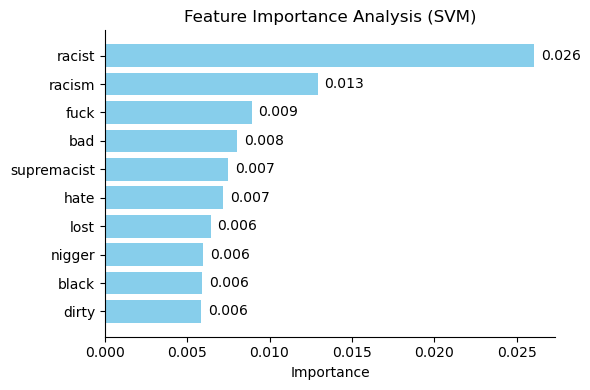

In [855]:
# Extract top 10 features and their importances
top_features = importance_results.head(10)
words = top_features['feature']
drops = top_features['importance']

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = plt.barh(words, drops, color='skyblue')

for bar, drop in zip(bars, drops):
    plt.annotate(f'{drop:.3f}', 
                 xy=(drop, bar.get_y() + bar.get_height() / 2), 
                 xytext=(5, 0), 
                 textcoords='offset points',
                 ha='left', 
                 va='center')

plt.xlabel('Importance')
plt.title('Feature Importance Analysis (SVM)')
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('feature_importance_analysis.jpg')
plt.show()

**Key Insights:** 

From the above visualization, we can notice some of the most important words contributing to our model's performance. For example, 'racist' and 'racism' were the top two features that together if they were removed, would cause a combined 0.039 drop (0.026 and 0.013 respectively) in the F1 score. In other words, mentions of 'racist' and 'racism' were pretty strong indicators of bias.
In addition, we can also observe mentions of hate speech and racial slurs that indicates that mentions of racial terms were also key indicators in detecting bias.

On the other hand, one could also argue that such high importance of terms such as 'racist' and 'racism' may be a potential risk of overfitting as the model might struggle to detect bias if a content doesn't have these specific terms

**c) Sensitivity Analysis**: 

We performed sensitivity analysis on our LSTM model by focusing on the impact of dropout rates while keeping the other parameters the same. We chose different range of dropout rates because it is an important hyperparameter that prevents overfitting and can significantly impact our model's performance.

In [748]:
def sensitivity_analysis(vocab_size, embedding_dim, lstm_units, dropout_rates, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
    results = []
    
    for dropout_rate in dropout_rates:
        model = create_lstm_model(vocab_size, embedding_dim, lstm_units, dropout_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        y_pred = np.argmax(model.predict(X_val), axis=-1)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        results.append({
            'dropout_rate': dropout_rate,
            'accuracy': accuracy,
            'f1': f1
        })
    
    return pd.DataFrame(results)

# Range of dropout rates
dropout_rates = [0.3, 0.4, 0.5, 0.6, 0.7]

# Perform sensitivity analysis
sensitivity_res = sensitivity_analysis(5000, 100, 100, dropout_rates, X_train_pad, y_train, X_test_pad, y_test)

print(sensitivity_res)

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
   dropout_rate  accuracy        f1
0           0.3  0.672386  0.671786
1           0.4  0.669358  0.670072
2           0.5  0.680333  0.674051
3           0.6  0.685505  0.681374
4           0.7  0.675413  0.675466


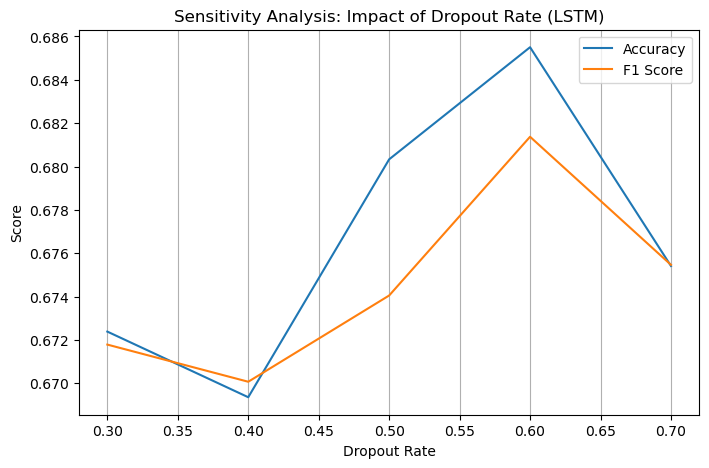

In [749]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(sensitivity_res['dropout_rate'], sensitivity_res['accuracy'], label='Accuracy')
plt.plot(sensitivity_res['dropout_rate'], sensitivity_res['f1'], label='F1 Score')
plt.xlabel('Dropout Rate')
plt.ylabel('Score')
plt.title('Sensitivity Analysis: Impact of Dropout Rate (LSTM)')
plt.legend()
plt.grid(True, axis='x')
plt.savefig('sensitivity_analysis.jpg')
plt.show()

**Key Insights:** 

As we can see from the above visualization, how sensitive both 'Accuracy' and 'F1 score' are to changes in the dropout rate. As the dropout rate is increasing, we can observe the performance of the model before reaching a peak performance at a dropout rate of 0.6. This indicates the optimal range as we can notice the drop in performance as the dropout rate is increased beyond 0.6. 

**d) Tradeoffs Analysis:** 

Given the evaluation results and metrics used, we can observe several tradeoffs. Some of them are mentioned below:

1. The more obvious tradeoff noticed was between a model's complexity and it's performance. Model such as 'BERT' and 'LSTM' showed good performance results but this was at the cost of higher complexity and training time compared to classic ML algorithms.
2. The second one was between speed and accuracy as simpler models such as 'SGD' takes little time to train and predict. But obviously they don't achieve the same accuracy as more advanced models such as 'BERT' and 'LSTM'.

But let't take a closer look at our LSTM model and try to analyze the tradeoff between its training data size and accuracy, and between its training time and accuracy:

In [752]:
def tradeoff_analysis(X_train, y_train, X_test, y_test):
    train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
    accuracies = []
    train_times = []
    
    for size in train_sizes:
        X_train_subset = X_train[:int(len(X_train) * size)]
        y_train_subset = y_train[:int(len(y_train) * size)]
        
        model = create_lstm_model(5000, 100, 100, 0.5)
        
        start_time = time.time()
        model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=64, verbose=0)
        train_time = time.time() - start_time
        
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        
        accuracies.append(accuracy)
        train_times.append(train_time)
    
    return train_sizes, accuracies, train_times

train_sizes, accuracies, train_times = tradeoff_analysis(X_train_pad, y_train, X_test_pad, y_test)

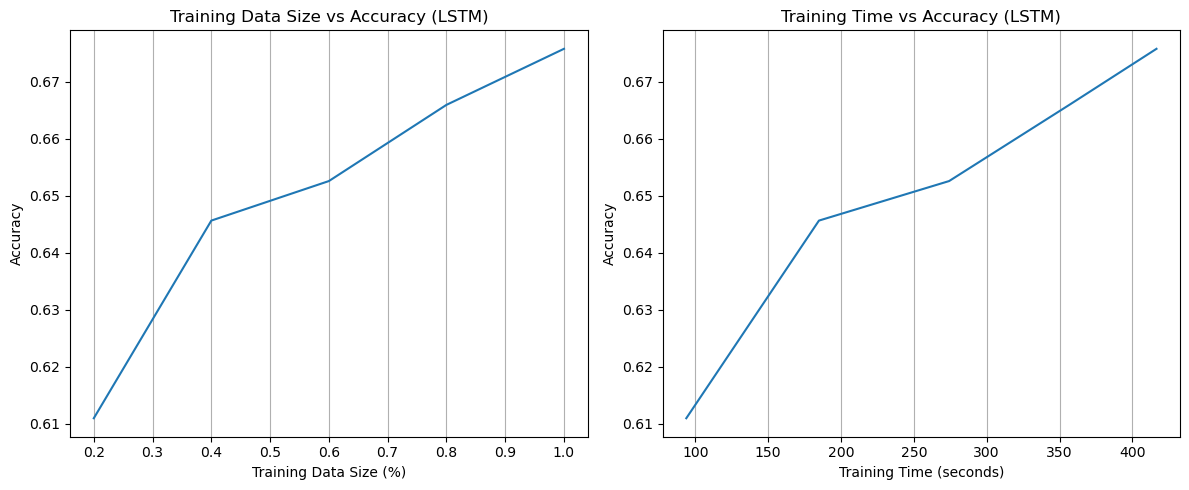

In [753]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_sizes, accuracies)
ax1.set_title('Training Data Size vs Accuracy (LSTM)')
ax1.set_xlabel('Training Data Size (%)')
ax1.set_ylabel('Accuracy')
ax1.grid(True, axis='x')

ax2.plot(train_times, accuracies)
ax2.set_title('Training Time vs Accuracy (LSTM)')
ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('Accuracy')
ax2.grid(True, axis='x')

plt.tight_layout()
plt.savefig('tradeoff_analysis.jpg')
plt.show()

**Key Insights:** 

From the above visualization, we can see a common pattern that as both training data size and training time increases, our model's accuracy is also increasing.

Training Data Size vs Accuracy (LSTM) Plot:
In this plot, we can observe a significant increase in model's accuracy as the training data size increases from 20% to 60% but the rate of improvement in accuracy slows beyond 60%. At 100%, it peaks at its highest accuracy. This indicates a clear tradeoff where more data is definitely important for the model's training and better accuracy but the benefit starts decreasing after a certain point.

Training Time vs Accuracy (LSTM) Plot:
In this plot, we can see a similar pattern as training data size. As training time is increasing so does the model's accuracy. Initially, the model's accuracy increased significantly but slows beyond 250 seconds of training and peaks at a little over 400 seconds. This also highlights the tradeoff between time and performance as more training time does improve its performance but after a certain point, it increases at a slower rate.

Together, the above tradeoff analysis highlights the importance of carefully considering the specific requirements when selecting a model and fine-tuning it.

#### Failure Analysis
Finally, we analyzed specific examples where our best model failed to make correct predictions.

In [756]:
def analyze_failures(model, X, y, texts, is_lstm=False):
    if is_lstm:
        y_pred = np.argmax(model.predict(X), axis=-1)
    else:
        y_pred = model.predict(X)
    errors = np.where(y != y_pred)[0]
    for i in errors[:3]:
        print(f"True label: {le.inverse_transform([y.iloc[i]])[0]}")
        print(f"Predicted label: {le.inverse_transform([y_pred[i]])[0]}")
        print(f"Text: {texts.iloc[i]}\n")

# Analyze failures for the best performing model
best_model_index = np.argmax([r['F1'] for r in results])
best_model = models[best_model_index]
is_lstm = model_names[best_model_index] == 'LSTM'
X_test_list = [X_test_tfidf, X_test_tfidf, X_test_pad]
analyze_failures(best_model, X_test_list[best_model_index], y_test, X_test, is_lstm)

248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
True label: Highly Biased
Predicted label: Neutral
Text: bloor lansdowne gentrified dread think like

True label: Slightly Biased
Predicted label: Highly Biased
Text: twitter done everyone else blacking look bit foolish

True label: Neutral
Predicted label: Slightly Biased
Text: newcomer know think pfd draw lot people think wide open drug market attracting certain element

